In [1]:
import sys
sys.path.append('../library')
sys.path.append('../library/rtde')
import logging
import rtde.rtde as rtde
import rtde.rtde_config as rtde_config
import time
import math
import subprocess
import socket 
import os
from quaternion import quaternion
from transform_coordinate import transform_coordinate
import keyboard
from IPython.display import clear_output
from itertools import cycle
import numpy as np

# c: left controller pose
# (l/r)t: (left/right) trigger
# (l/r)f: (left/right) fist
# (l/r)j(p/u/d//l/r): (left/right) joy stick (press/up/down/left/right)
# s: left start

# 0 1 2 3 4 5 6 7 8 9 10  11  12  13  14  15 16 17 18 19 20  21  22  23  24  25 26  
# c c c c c c c A B ? rjp rju rjd rjl rjr rt rf x  y  s  ljp lju ljd ljl ljr lt lf

In [2]:
#logging.basicConfig(level=logging.INFO)

ROBOT_HOST = '192.168.253.1'
ROBOT_PORT = 30004
config_filename = '../config/pose_pilot_configuration_with_button_gripper.xml'

UDP_IP = "127.0.0.1"
UDP_PORT = 5005
sock = socket.socket(socket.AF_INET, # Internet
                     socket.SOCK_DGRAM) # UDP
#sock.setblocking(0)
sock.bind((UDP_IP, UDP_PORT))


keep_running = True
#logging.getLogger().setLevel(logging.INFO)

In [3]:
conf = rtde_config.ConfigFile(config_filename)
state_names, state_types = conf.get_recipe('state')
setp_names, setp_types = conf.get_recipe('setp')
watchdog_names, watchdog_types = conf.get_recipe('watchdog')
button_names, button_types = conf.get_recipe('button')
gripper_names, gripper_types = conf.get_recipe('gripper')

In [4]:
con = rtde.RTDE(ROBOT_HOST, ROBOT_PORT)
con.connect()

# get controller version
con.get_controller_version()

# setup recipes
con.send_output_setup(state_names, state_types)
setp = con.send_input_setup(setp_names, setp_types)
watchdog = con.send_input_setup(watchdog_names, watchdog_types)
button = con.send_input_setup(button_names, button_types)
gripper = con.send_input_setup(gripper_names, gripper_types)

In [5]:
def last_infinite_state(coming_from_state, finite_long_states):
    found = False
    while not found:
        if len(coming_from_state) == 0:
            return None
        s = coming_from_state.pop()
        if not s in finite_long_states:
            found = True
    return s

In [6]:
def setp_to_list(setp):
    list = []
    for i in range(0,6):
        list.append(setp.__dict__["input_double_register_%i" % i])
    return list

def list_to_setp(setp, list):
    for i in range (0,6):
        setp.__dict__["input_double_register_%i" % i] = list[i]
    return setp

def button_to_list(button):
    list = []
    for i in range(0,3):
        list.append(button.__dict__["input_int_register_%i" % (i+1)])
    return list

def list_to_button(button, list):
    for i in range (0,3):
        button.__dict__["input_int_register_%i" % (i+1)] = list[i]
    return button

def gripper_to_list(button):
    list = []
    for i in range(0,3):
        list.append(button.__dict__["input_int_register_%i" % (i+4)])
    return list

def list_to_gripper(button, list):
    for i in range (0,3):
        button.__dict__["input_int_register_%i" % (i+4)] = list[i]
    return button

In [7]:
class controller_button:
    def __init__(self, button_list_names):
        self.names = button_list_names
        self.names_ix = dict([(self.names[i], i) for i in range(len(self.names))])
        self.values = [0 for b in self.names]
        self.last_values = [0 for b in self.names]

    def update(self, button_vals):
        self.last_values = self.values
        self.values = button_vals

    def get(self, name):
        return self.values[self.names_ix[name]]
    def get_last(self, name):
        return self.last_values[self.names_ix[name]]
    def get_just_pushed(self, name):
        return self.get(name) > 0 and (not (self.get_last(name) > 0))
    def get_just_released(self, name):
        return (not (self.get(name) > 0)) and (self.get_last(name) > 0)
    def get_kept_released(self, name):
        return (not (self.get(name) > 0)) and (not (self.get_last(name) > 0))
    def get_kept_pushed(self, name):
        return (self.get(name) > 0) and (self.get_last(name) > 0)

In [8]:
class operating_state:
    def __init__(self, state, t):
        self.current = state
        self.last = "not_awake"
        self.last_update_t = t
        self.change_state_to_asap = ""
        self.init = False
        
    def update(self, t):
        # To make sure in each iteration we update the operating state exactly once
        assert self.last_update_t < t
        assert not self.change_state_to_asap == ""
        
        self.last = self.current
        self.current = self.change_state_to_asap
        self.last_update_t = t
        self.change_state_to_asap = ""
        self.init = True
        
    def is_init(self):
        if self.init == True:
            self.init = False
            return True
        return False

class robot_state:
    def __init__(self):
        self.state = []
        self.last_state = []
    def update(self, state):
        self.last_state = self.state
        self.state = state
        
class controller_to_robot_transformation:
    def __init__(self, con_base_loc, con_base_ori_aangle, rob_base_loc, rob_base_ori_aangle, tr_con_rob_cor):
        # set current controller loc-ori to current rob loc-ori
        con_base_ori = quaternion.axis_angle_to_quaternion(con_base_ori_aangle)
        self.tr_con_cor = transform_coordinate(con_base_loc, con_base_ori, con_base_ori) 
            
        # get robot coordinates transformations
        rob_base_ori = quaternion.axis_angle_to_quaternion(rob_base_ori_aangle)
        self.tr_rob_cor = transform_coordinate(rob_base_loc, rob_base_ori, rob_base_ori)
        
        self.tr_con_rob_cor = tr_con_rob_cor
    
    def get_rob_pose_from_con_pose(self, con_loc, con_ori_aangle):
        con_ori = quaternion.axis_angle_to_quaternion(con_ori_aangle)

        rel_con_loc, rel_con_ori = self.tr_con_cor.to_new(con_loc, con_ori)
        rel_rob_loc, rel_rob_ori = self.tr_con_rob_cor.to_new(rel_con_loc, rel_con_ori)
        rob_loc, rob_ori = self.tr_rob_cor.to_old(rel_rob_loc, rel_rob_ori)
        return rob_loc, rob_ori

In [9]:
op_state = operating_state("not_awake", 1)
op_state.init = True
op_state.is_init() == True

True

In [10]:
# Initialization

# Loop count
loop_iteration_num = 1 

# setp
setp.input_double_register_0 = 0
setp.input_double_register_1 = 0
setp.input_double_register_2 = 0
setp.input_double_register_3 = 0
setp.input_double_register_4 = 0
setp.input_double_register_5 = 0

# button
button.input_int_register_1 = 0
button.input_int_register_2 = 0

# gripper
gripper.input_int_register_4 = 0
gripper.input_int_register_5 = 0
gripper.input_int_register_6 = 0

  
# The function "rtde_set_watchdog" in the "rtde_control_loop.urp" creates a 1 Hz watchdog
watchdog.input_int_register_0 = 0

# tracking config object
tr_conf = None

# controller to robot gripper transformation
tr_con_rob_rot_vec_aangle = [0, math.pi, 0]
tr_con_rob_rot_vec = quaternion.axis_angle_to_quaternion(tr_con_rob_rot_vec_aangle)
tr_con_rob_cor = transform_coordinate([0, 0, 0], quaternion(1, 0, 0, 0), tr_con_rob_rot_vec)

# state variables
finite_long_states = ["auto", "reach"]
c_button = controller_button(['a', 'b', '?', 'rjp', 'rju', 'rjd', 'rjl', 'rjr', 'rt', 'rf', 
                   'x', 'y', 's', 'ljp', 'lju', 'ljd', 'ljl', 'ljr', 'lt', 'lf'])
op_state = operating_state("not_awake", loop_iteration_num)
rob_state = robot_state()
coming_from_state = []

# safety params
safe_max_joint_speed_start = 10
safe_max_distance_between_states = 0.01

# Force
contact_force_threshold = 30
rob_in_contact = False

# variables sent to robot
is_free_driving = False
is_reaching = False

# auto params
traj_v_default = 1
last_saved = []
second_last_saved = []
saved_auto_file1 = []
saved_auto_file2 = []
saved_traj = []
traj_v = traj_v_default
auto_finish_freedrive_length = 100

# saving params
traj_dir = "../trajectories/circle/"
saved_auto_file1_name = "circle_new"
saved_auto_file2_name = ""
is_saving = False
start_saving = False
finish_saving = False

# gripper params
gripper_force = 100 # 0 to 100 integer
gripper_speed = 100 # 0 to 100 integer
gripper_loc = 100 # 0 to 100 integer

In [11]:
## Load last trajectory file name and trajectory
if traj_dir[-1] != '/':
    traj_dir = traj_dir + '/'
traj_dir_name = traj_dir.split('/')[-2]
traj_dir_file_names = os.listdir(traj_dir)
if saved_auto_file1_name in traj_dir_file_names:
    traj_dir_file_names.remove(saved_auto_file1_name)
if saved_auto_file2_name in traj_dir_file_names:
    traj_dir_file_names.remove(saved_auto_file2_name)
if len(traj_dir_file_names) > 0:
    last_file_name = traj_dir_file_names[-1]
else:
    last_file_name = ""

if last_file_name != "":
    last_file_num = int(last_file_name.split(traj_dir_name)[-1])
else: 
    last_file_num = 0

# Load trajectories
if saved_auto_file1_name != "":
    load_traj_file_path = traj_dir + saved_auto_file1_name
    with open(load_traj_file_path) as f:
        content = f.readlines()
    saved_auto_file1 = [[float(point) for point in line.split(',')] for line in content]
    
if saved_auto_file2_name != "":
    load_traj_file_path = traj_dir + saved_auto_file2_name
    with open(load_traj_file_path) as f:
        content = f.readlines()
    saved_auto_file2 = [[float(point) for point in line.split(',')] for line in content]

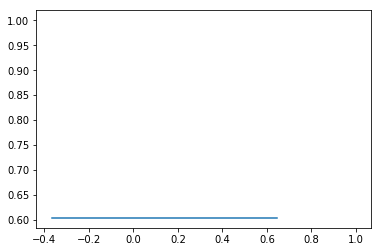

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
x = np.array([t[0] for t in saved_auto_file1])

z = np.array([t[1] for t in saved_auto_file1])
l = plt.plot(x, z, 1, 1)
plt.show()

In [13]:
#start data synchronization
if not con.send_start():
    sys.exit()

# control loop
while keep_running:
    loop_iteration_num = loop_iteration_num + 1
    # Receive current state of robot
    rob_state.update(con.receive())
    
    # If connection is broken break
    if rob_state.state is None:
        break;
    
    # Send data to Unity
    net_torque = (rob_state.state.actual_TCP_force[3]**2 + 
                  rob_state.state.actual_TCP_force[4]**2 + 
                  rob_state.state.actual_TCP_force[5]**2)**0.5
    #net_torque = np.linalg.norm(np.array(rob_state.state.actual_TCP_force[3:6]))
    
    sock.sendto((str(rob_state.state.tcp_force_scalar) + "," +
                 str(net_torque) + "," +
                 str(1) + "," +
                 str(77) + "," + 
                 str(len(saved_traj)) + "," +
                 str(0)), ("127.0.0.1", 11000))
    
    # Receieve data from Unity
    data, addr = sock.recvfrom(1024) # buffer size is 1024 bytes
    controller_state = [float(s) for s in data.split(',')]
    
    # Get controller pose
    # Unity sends left handed coordinate, we need to convert it to right handed
    controller_state[2] = -controller_state[2]
    controller_state[5] = -controller_state[5]
    controller_state[6] = -controller_state[6]*math.pi/180.0
    
    con_loc = controller_state[0:3]
    con_ori_aangle = [i*controller_state[6] for i in controller_state[3:6]]
     
    # Get latest controller's buttons states
    c_button.update(controller_state[7:])
    #print(c_button.values)
    #print(c_button.names_ix)
    #print(c_button.names)
    # lt to tracking
    if c_button.get_just_pushed("lt")  == True:
        op_state.change_state_to_asap = "tracking"
    # lf to not_tracking
    elif c_button.get_just_pushed("lf") == True:
        op_state.change_state_to_asap = "not_tracking"
    # s configure
    elif c_button.get_just_pushed("s") == True:
        if op_state.current == "not_tracking":
            tr_conf = controller_to_robot_transformation(con_loc, con_ori_aangle, 
                                                         rob_state.state.actual_TCP_pose[0:3], 
                                                         rob_state.state.actual_TCP_pose[3:6], 
                                                         tr_con_rob_cor)
            print("Configuration updated.")
    # x save/finish saving
    elif c_button.get_just_pushed("x")  == True:
        if is_saving == False:
            is_saving = True
            start_saving = True
        else:
            is_saving = False
            finish_saving = True    
    # y to surface
    elif c_button.get_just_pushed("y")  == True:
        op_state.change_state_to_asap = "surface"
            
    # ljp to freedrive
    elif c_button.get_just_pushed("ljp")  == True:
        op_state.change_state_to_asap = "freedrive"
            
    # a to auto play file 1
    elif c_button.get_just_pushed("a")  == True:
        saved_traj = saved_auto_file1
        op_state.change_state_to_asap = "auto"
        
    # b to auto play file 2
    elif c_button.get_just_pushed("b")  == True:
        saved_traj = saved_auto_file2
        op_state.change_state_to_asap = "auto"
    # rt to auto play last save
    elif c_button.get_just_pushed("rt")  == True:
        saved_traj = last_saved
        op_state.change_state_to_asap = "auto"
    # rf to auto play second last save
    elif c_button.get_just_pushed("rf")  == True:
        saved_traj = second_last_saved
        op_state.change_state_to_asap = "auto"
    # rjp to pause/play auto
    elif c_button.get_just_pushed("rjp")  == True:
        if traj_v == 0:
            traj_v = traj_v_default
        else:
            traj_v = 0
    # rju faster auto
    elif c_button.get_just_pushed("rju")  == True:
        traj_v = traj_v*4
    # rjd slower auto
    elif c_button.get_just_pushed("rjd")  == True:
        traj_v = int(traj_v/2)
    # rjr play auto forward
    elif c_button.get_just_pushed("rjr")  == True:
        traj_v = traj_v_default
    # rjl play auto backward
    elif c_button.get_just_pushed("rjl")  == True:
        traj_v = -traj_v_default
    elif c_button.get_just_pushed("lju")  == True:
        gripper_loc = 0
    elif c_button.get_just_pushed("ljl")  == True:
        if gripper_loc == 0:
            gripper_force = 10
            gripper_loc = 100
    elif c_button.get_just_pushed("ljr")  == True:
        if gripper_loc == 0:
            gripper_force = 100
            gripper_loc = 100
        
    # Make sure the robot is awake
    if (not rob_state.state.runtime_state == 2) and (not op_state.current == "not_awake"):
        op_state.change_state_to_asap = "not_awake"
        print("last state before not awake: " + op_state.current)
        print("is free driving:" + str(is_free_driving))
        
    # Is robot in contact?
    last_rob_in_contact = rob_in_contact
    rob_in_contact =  rob_state.state.tcp_force_scalar >= contact_force_threshold
    if rob_in_contact and not last_rob_in_contact:
        contact_z = rob_state.state.actual_TCP_pose[2]
        print("contact detected at: " + str(contact_z))
    
    if op_state.init == True:
        print(op_state.current)
    
    ### not_awake
    if op_state.current == "not_awake":
        if op_state.is_init() == True:
            pass
        elif not op_state.change_state_to_asap == "":
            op_state.update(loop_iteration_num)
        else:
            if rob_state.state.runtime_state == 2:
                op_state.change_state_to_asap = "not_tracking"
         
        new_setp = rob_state.state.actual_TCP_pose       

    ### auto
    elif op_state.current == "auto":
        # todo when just got to this state
        if op_state.is_init() == True:
            if not op_state.last in finite_long_states:
                coming_from_state = [op_state.last]
            else:
                coming_from_state.append(op_state.last)
                
            if max(rob_state.state.actual_qd) > safe_max_joint_speed_start:
                # TODO: Robot sudden stop to not awake
                break
            elif tr_conf == None:
                print("No config object was found. Please configure the robot first before first before starting in auto mode.")
                op_state.change_state_to_asap = op_state.last
            elif len(saved_traj) == 0:
                print("This trajectory is empty.")
                op_state.change_state_to_asap = last_infinite_state(coming_from_state, finite_long_states)
            else:
                target_loc = np.array(saved_traj[0][0:3])
                current_loc = np.array(rob_state.state.actual_TCP_pose[0:3])
                distance = np.linalg.norm(target_loc-current_loc)
                if distance > safe_max_distance_between_states:
                    reach_target = saved_traj[0]
                    op_state.change_state_to_asap = "reach"
                traj_i = 0
                traj_v = traj_v_default
                traj_finished_i = auto_finish_freedrive_length
            new_setp = rob_state.state.actual_TCP_pose
        # todo before leaving the state
        elif not op_state.change_state_to_asap == "":
            # Make sure robot is slow enough
            if traj_finished_i < auto_finish_freedrive_length:
                is_free_driving = True
                traj_finished_i = traj_finished_i + 1
            else:
                is_free_driving = False
                op_state.update(loop_iteration_num)
                
            new_setp = rob_state.state.actual_TCP_pose
        # todo while at the state
        else:
            traj_i = traj_i + traj_v
            if traj_i >= len(saved_traj):
                op_state.change_state_to_asap = last_infinite_state(coming_from_state, finite_long_states)
                traj_finished_i = 0
                new_setp = saved_traj[len(saved_traj)-1]
            elif traj_i < 0:
                op_state.change_state_to_asap = last_infinite_state(coming_from_state, finite_long_states)
                traj_finished_i = 0
                new_setp = saved_traj[0]
            else:
                new_setp = saved_traj[traj_i]
            
            if rob_in_contact == True:
                op_state.change_state_to_asap = last_infinite_state(coming_from_state, finite_long_states)
                traj_finished_i = 0
                
    
    ### surface
    # TODO: currently constant y-pose is implemented
    elif op_state.current == "surface":
        # todo when just got to this state
        if op_state.is_init() == True:
            if max(rob_state.state.actual_qd) > safe_max_joint_speed_start:
                # TODO: Robot sudden stop to not awake
                break
            elif tr_conf == None:
                print("No config object was found. Please configure the robot first before starting in surface mode.")
                op_state.change_state_to_asap = op_state.last
            else:
                rob_loc, rob_ori = tr_conf.get_rob_pose_from_con_pose(con_loc, con_ori_aangle)
                target_loc = np.array(rob_loc)
                current_loc = np.array(rob_state.state.actual_TCP_pose[0:3])
                distance = np.linalg.norm(target_loc-current_loc)
                if distance > safe_max_distance_between_states:
                    reach_target = rob_loc + rob_ori.to_axis_angle()
                    op_state.change_state_to_asap = "reach"
                surface_point = rob_state.state.actual_TCP_pose
            new_setp = rob_state.state.actual_TCP_pose
        # todo before leaving the state
        elif not op_state.change_state_to_asap == "":
            # TODO: slow down the robot then change state
            op_state.update(loop_iteration_num)
            new_setp = rob_state.state.actual_TCP_pose
        # todo while at the state
        else:
            rob_loc, rob_ori = tr_conf.get_rob_pose_from_con_pose(con_loc, con_ori_aangle)
            
            # Z correction for contact
            if rob_in_contact and rob_loc[2] <= contact_z:
                rob_loc[2] = contact_z
            
            # surface correction
            rob_loc[1] = surface_point[1]
            new_setp = rob_loc + surface_point[3:]           
    
    ### freedrive
    elif op_state.current == "freedrive":
        # todo when just got to this state
        if op_state.is_init() == True:
            if max(rob_state.state.actual_qd) > safe_max_joint_speed_start:
                # TODO: Robot sudden stop to not awake
                break
            new_setp = rob_state.state.actual_TCP_pose
        # todo before leaving the state
        elif not op_state.change_state_to_asap == "":
            is_free_driving = False
            op_state.update(loop_iteration_num)
            new_setp = rob_state.state.actual_TCP_pose
        # todo while at the state
        else:
            is_free_driving = True

    
    ### tracking
    elif op_state.current == "tracking":
        # todo when just got to this state
        if op_state.is_init() == True:
            print("start tracking")
            if max(rob_state.state.actual_qd) > safe_max_joint_speed_start:
                # TODO: Robot sudden stop to not awake
                break
            elif tr_conf == None:
                print("No config object was found. Please configure the robot first before starting in tracking mode.")
                op_state.change_state_to_asap = op_state.last
            else:
                rob_loc, rob_ori = tr_conf.get_rob_pose_from_con_pose(con_loc, con_ori_aangle)
                target_loc = np.array(rob_loc)
                current_loc = np.array(rob_state.state.actual_TCP_pose[0:3])
                distance = np.linalg.norm(target_loc-current_loc)
                if distance > safe_max_distance_between_states:
                    reach_target = rob_loc + rob_ori.to_axis_angle()
                    op_state.change_state_to_asap = "reach"
            new_setp = rob_state.state.actual_TCP_pose
        # todo before leaving the state
        elif not op_state.change_state_to_asap == "":
            print("finish tracking")
            # TODO: slow down the robot then change state
            op_state.update(loop_iteration_num)
            new_setp = rob_state.state.actual_TCP_pose
        # todo while at the state
        else:
            rob_loc, rob_ori = tr_conf.get_rob_pose_from_con_pose(con_loc, con_ori_aangle)
            
            # Z correction for contact
            if rob_in_contact and rob_loc[2] <= contact_z:
                rob_loc[2] = contact_z
                
            new_setp = rob_loc + rob_ori.to_axis_angle()
            
    ### reach
    elif op_state.current == "reach":
        # todo when just got to this state
        if op_state.is_init() == True:
            is_reaching = False
            if not op_state.last in finite_long_states:
                coming_from_state = [op_state.last]
            else:
                coming_from_state.append(op_state.last)
            
            if reach_target == None or reach_target == []:
                print("Error: Reach with no reaching target")
                break
                
            if max(rob_state.state.actual_qd) > safe_max_joint_speed_start:
                # TODO: Robot sudden stop to not awake
                break
            new_setp = rob_state.state.actual_TCP_pose
        # todo before leaving the state
        elif not op_state.change_state_to_asap == "":
            is_reaching = False
            reach_target = []
            if max(rob_state.state.actual_qd) < safe_max_joint_speed_start:
                op_state.update(loop_iteration_num)
            else: 
                print("Error: reach finishes too fast!!!")
                break
            new_setp = rob_state.state.actual_TCP_pose
        # todo while at the state
        else:
            is_reaching = True
            target_loc = np.array(reach_target[0:3])
            current_loc = np.array(rob_state.state.actual_TCP_pose[0:3])
            distance = np.linalg.norm(target_loc-current_loc)
            if distance < safe_max_distance_between_states:
                op_state.change_state_to_asap = coming_from_state.pop()
            new_setp = reach_target
            
    ### not_tracking
    elif op_state.current == "not_tracking":
        # todo when just got to this state
        if op_state.is_init() == True:
            if max(rob_state.state.actual_qd) > safe_max_joint_speed_start:
                # TODO: Robot sudden stop to not awake
                break;
            new_setp = rob_state.state.actual_TCP_pose
        # todo before leaving the state
        elif not op_state.change_state_to_asap == "":
            op_state.update(loop_iteration_num)
            new_setp = rob_state.state.actual_TCP_pose
        # todo while at the state
        else:
            new_setp = rob_state.state.actual_TCP_pose
    
    # none
    else:
        print("Not in a valid state.")
        break
    
#     print("state: " + op_state.current)
#     print("is_free_driving: " + str(is_free_driving))
#     print("force: " + str(rob_state.state.tcp_force_scalar))
#     print("net torque: " + str(net_torque))
#     cur_loc = np.array(rob_state.state.actual_TCP_pose[0:3])
#     target_loc = np.array(new_setp[0:3])
#     print("Distance to target: " + str(np.linalg.norm(target_loc-cur_loc)))
    
    # Save
    if is_saving == True:
        if start_saving == True:
            print("Started saving trajectory.")
            saved_traj = []
            start_saving = False
        saved_traj.append(rob_state.state.actual_TCP_pose)
    else:
        if finish_saving == True and saved_traj != []:
            last_file_num = last_file_num + 1
            save_file_path = traj_dir + traj_dir_name + str(last_file_num)
            with open(save_file_path, 'w') as f:
                for pose in saved_traj:
                    f.write(",".join([str(point) for point in pose]) + '\n')
                    
            second_last_saved = last_saved
            last_saved = saved_traj
            finish_saving = False
            print("Finished saving trajectory.")
        
    # Change robot data to it's acceptable format
    list_to_setp(setp, new_setp)
    #print(new_setp)
    #print(rob_state.state.actual_TCP_pose)
    list_to_button(button, [int(is_free_driving),
                            int(is_reaching),
                           int(0)]) # TODO: the logic for isJoint needs to be added
    list_to_gripper(gripper, [int(gripper_force),
                              int(gripper_loc),
                              int(gripper_speed)])
    
    
    # Send data to robot 
    con.send(button)
    con.send(gripper)
    con.send(setp)
    con.send(watchdog)

not_tracking
Configuration updated.
tracking
start tracking
finish tracking
not_tracking
last state before not awake: not_tracking
is free driving:False
not_awake


error: [Errno 10054] An existing connection was forcibly closed by the remote host

In [ ]:
a = ["1", "2"]
a.pop()
a

In [ ]:
con.send_pause()
con.disconnect()
sys.stdout.flush()